# Training DQN Agent on Snake using Jumanji API
This notebook is an example of how to use the Jumanji API to train a Deep-RL agent. We will train a [DQN](https://arxiv.org/abs/1312.5602) agent on the `"Snake-v1"` Jumanji environment under the Anakin framework. The Anakin design was developed by Matteo Hessel, Manuel Kroiss, Fabio Viola and Hado van Hasselt in [Podracer architectures for scalable Reinforcement Learning](https://arxiv.org/abs/2104.06272).

**Aims:**
* Understand the basics of the Jumanji API.
* Solve the `"Snake-v1"` environment with a DQN using the Anakin framework.

**Prerequisites:**
* Familiarity with [JAX](https://jax.readthedocs.io/en/latest/beginner_guide.html#beginner-guide).
* Familiarity with some Deep Reinforcement Learning algorithms. ([DQN Tutorial](https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc)) 

## Install and Import

In [1]:
%%capture
! pip3 install -U pip

# if using a GPU
! pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# if using a TPU 
#! pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html # tpu

! pip install jaxlib
! pip3 install dm-haiku
! pip3 install optax 
! pip3 install matplotlib
! pip3 install jumanji
! pip3 install tensorflow
! pip3 install tensorrt
! pip3 install chex
! pip3 install rlax
! pip3 install tqdm

In [2]:
# ensure GPU is not preallocating space
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

import jax
import warnings

accelerator_type = jax.devices()[0].platform

if accelerator_type == 'tpu':
    # setup TPU
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print("Running with TPU!")

elif accelerator_type == "gpu":
    print("Running with GPU!")

else:
    print("Running with CPU!")
    warnings.warn(
        "Running with CPU. We reccomend running this notebook in Colab with TPU enabled,"
        "or GPU if TPU is not available."
    )

import jax.numpy as jnp
import jaxlib
from jax.lib import xla_bridge
from jax import lax
import tensorrt
import tensorflow as tf

import haiku as hk
import optax
import rlax
import timeit
import chex

import numpy as np
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from typing import Sequence, Tuple, Callable, Any

import jumanji
from jumanji.wrappers import AutoResetWrapper
from jumanji.environments.routing.snake import State, Observation, Snake
from jumanji.types import TimeStep

# prevent TensorFlow from allocating GPU memory
tf.config.set_visible_devices([], "GPU")

# for VScode output
%matplotlib inline

Running with GPU!


## Basic usage of Jumanji
We implement a 10 step episode to illustrate the basic usage of a Jumanji environment. 

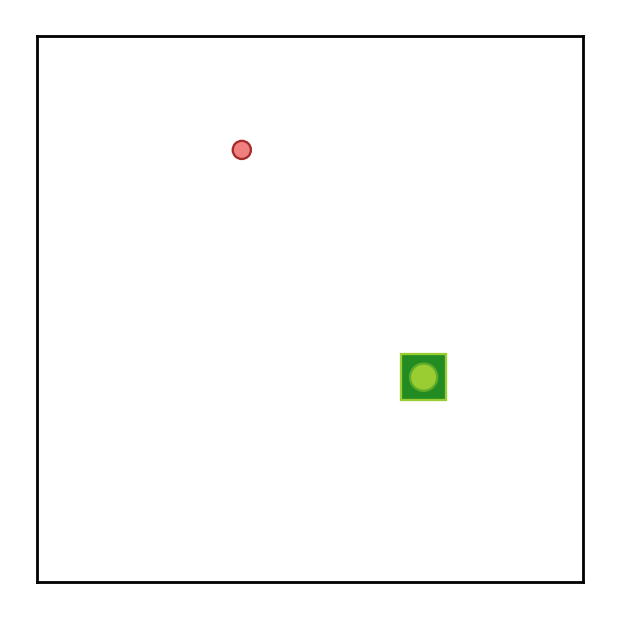

In [3]:
# initialise environment
env = jumanji.make("Snake-v1")
num_actions = env.action_spec().num_values

# generate PRNG key for randomness
rng = jax.random.PRNGKey(0)

# reset the environment and receive the initial state and timestep
state, timestep = env.reset(rng)

# jit environment step function
env_step = jax.jit(env.step)

# run episode for 10 steps
done = False
transitions = 0
while not done and transitions < 10:
    # generate new key
    rng, _ = jax.random.split(rng)

    # select action randomly
    action = jax.random.randint(rng, (), 0, num_actions)

    # transition to next state
    state, timestep = env_step(state, action)
    transitions += 1

    # validate action
    done = not timestep.discount

    # render environment
    env.render(state)


## Deep Q-Network
Here, we define the DQN's architecture and get the `q_values` of some `dummy_observation`.

In [4]:
def build_dqn(
    num_outputs: int,
    mlp_units: Tuple[int] = (128, 64),
    conv_n_channels: int = 32,
    time_limit: int = 5000,
):
    """Builds and returns Deep Q-Network"""

    def network_fn(observation: Observation) -> chex.Array:
        torso = hk.Sequential(
            [
                hk.Conv2D(conv_n_channels, (2, 2), 2),
                jax.nn.relu,
                hk.Conv2D(conv_n_channels, (2, 2), 1),
                jax.nn.relu,
                hk.Flatten(),
            ]
        )
        flat = hk.Flatten(preserve_dims=-2)

        # convolve the grid and flatten the output
        embedding = flat(torso(observation.grid))

        # concatenate the embedding with the step count
        norm_step_count = jnp.expand_dims(observation.step_count / time_limit, axis=-1)
        embedding = jnp.concatenate((embedding, norm_step_count), axis=-1)

        # pass the embedding through an MLP
        head = hk.nets.MLP((*mlp_units, num_outputs), activate_final=False)

        if num_outputs == 1:
            value = jnp.squeeze(head(embedding), axis=-1)
            return value
        else:
            logits = head(embedding)
            logits = jnp.where(
                observation.action_mask, logits, jnp.finfo(jnp.float32).min
            )
            return logits

    return hk.without_apply_rng(hk.transform(network_fn))


# build DQN and get dummy q-values
DQN = build_dqn(num_outputs=num_actions)

# initial DQN with a dummy observation
initial_parameters = DQN.init(rng, timestep.observation)

# jit apply method
model_apply = jax.jit(DQN.apply)

# get q_values
q_values = model_apply(initial_parameters, timestep.observation)

print(q_values)


[ 0.01263911  0.01044207  0.01907289 -0.00168083]


## Anakin Framework
The majority of the code below is copied verbatim from the [Podracer Architectures for Scalable RL](https://colab.research.google.com/drive/1974D-qP17fd5mLxy6QZv-ic4yxlPJp-G?usp=sharing#scrollTo=mGSmAiCHJsas).

**Additions**
* $\epsilon$-greedy action selection as apposed to a greedy selection
* Record metrics such as max and mean episode return per batch
* An evaluation step per batch

In [5]:
def get_evaluator(
    forward_pass: Callable,
    eval_env_reset: Callable,
    eval_env_step: Callable,
    rng: chex.PRNGKey,
    eval_batch_size: int = 5,
):
    """Returns method to evaluate currently policy"""

    def evaluate(params: hk.Params):
        def evaluate_one_episode(rng: chex.PRNGKey):
            def one_step(
                state: State,
                timestep: TimeStep,
                return_: chex.Numeric,
            ):
                action = jnp.argmax(forward_pass(params, timestep.observation))
                state, timestep = eval_env_step(state, action)
                return_ += timestep.reward
                return state, timestep, return_

            # reset environment and execute a single episode
            rng, _ = jax.random.split(rng)
            state, timestep = eval_env_reset(rng)
            *_, return_ = jax.lax.while_loop(
                lambda carry: ~carry[1].last(),
                lambda carry: one_step(*carry),
                (state, timestep, jnp.array(0, float)),
            )
            return return_

        # vmap to evaluate over batch of episodes
        rngs = jax.random.split(rng, eval_batch_size)
        returns = jax.vmap(evaluate_one_episode)(rngs)
        return jnp.mean(returns)

    return evaluate


Define useful containers.

In [6]:
class TimeIt:
    def __init__(self, tag, frames=None):
        self.tag = tag
        self.frames = frames

    def __enter__(self):
        self.start = timeit.default_timer()
        return self

    def __exit__(self, *args):
        self.elapsed_secs = timeit.default_timer() - self.start
        msg = self.tag + (": Elapsed time=%.2fs" % self.elapsed_secs)
        if self.frames:
            msg += ", FPS=%.2e" % (self.frames / self.elapsed_secs)
        print(msg)


@chex.dataclass(frozen=True)
class Experience:
    q_values: chex.Array
    action: chex.Array
    discount: chex.Array
    reward: chex.Array


@chex.dataclass(frozen=True)
class EpisodeMetrics:
    """Metrics that we use to keep track of the episode return and length
    throughout interation with the environment."""

    episode_return: chex.Array
    episode_length: chex.Array


### Define Learner Function

The method `get_learner_fn` returns a method `learner_fn` which:
* Collects a batch of experiences from a trajectory while recording any useful information. 
* Computes the squared TD($\lambda$) loss of the batch of experiences.
* Computes the gradient of the loss with respect to the network's parameters.
* Aggregates the gradient across a batch of trajectories, and across multiple devices (if using TPU).
* Updates the network's parameters with the Adam optimizer.
* Runs this update step multiple times without going back to python. The original Anakin implementation uses `jax.lax.fori` however we would like to obtain information from each step of the algoirthm. Therefore, we use `jax.lax.scan`.

In [7]:
def get_learner_fn(
    env_step: Callable,
    forward_pass: Callable,
    opt_update: Callable,
    rollout_len: int,
    agent_discount: float,
    lambda_: float,
    iterations: int,
    epsilon: float,
):
    """Define the minimal unit of computation in Anakin."""

    def loss_fn(
        params: hk.Params,
        outer_rng: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Compute the loss on a single trajectory."""

        def step_fn(carry, rng: chex.PRNGKey):
            env_state, env_timestep, episode_metrics = carry

            q_values = forward_pass(params, env_timestep.observation)
            action = rlax.epsilon_greedy(epsilon).sample(rng, q_values)
            next_env_state, next_env_timestep = env_step(env_state, action)
            reward = next_env_timestep.reward
            discount = next_env_timestep.discount

            info = {
                "episode_return": jnp.where(
                    discount == 0.0, reward + episode_metrics.episode_return, jnp.nan
                ),
                "episode_length": jnp.where(
                    discount == 0.0, 1 + episode_metrics.episode_length, jnp.nan
                ),
            }

            episode_metrics = EpisodeMetrics(
                episode_return=jnp.where(
                    discount == 0.0,
                    jnp.array(0.0),
                    reward + episode_metrics.episode_return,
                ),
                episode_length=jnp.where(
                    discount == 0.0, jnp.array(0), 1 + episode_metrics.episode_length
                ),
            )

            carry = next_env_state, next_env_timestep, episode_metrics
            return carry, (
                Experience(
                    q_values=q_values, action=action, discount=discount, reward=reward
                ),
                info,
            )

        # trajectory
        step_rngs = jax.random.split(outer_rng, rollout_len)
        (env_state, env_timestep, episode_metrics), (rollout, info) = lax.scan(
            step_fn, (env_state, env_timestep, episode_metrics), step_rngs
        )

        qa_tm1 = rlax.batched_index(rollout.q_values[:-1], rollout.action[:-1])

        # compute multi-step temporal difference error
        td_error = rlax.td_lambda(
            v_tm1=qa_tm1,  # predictions
            r_t=rollout.reward[1:],  # rewards
            discount_t=agent_discount * rollout.discount[1:],  # discount
            v_t=jnp.max(rollout.q_values[1:], axis=-1),  # bootstrap values
            lambda_=lambda_,  # mixing hyper-parameter lambda
        )

        # log info
        info = {
            "episode_return": jnp.nanmean(info["episode_return"], axis=0),
            "episode_length": jnp.nanmean(info["episode_length"], axis=0),
            "reward": jnp.mean(rollout.reward),
            "q_values": jnp.mean(qa_tm1),
            "max_episode_return": jnp.nanmax(info["episode_return"], axis=0),
        }

        return jnp.mean(td_error**2), (env_state, env_timestep, episode_metrics, info)

    def update_fn(
        params: hk.Params,
        opt_state: Tuple,
        rng: chex.PRNGKey,
        env_state: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Compute a gradient update from a single trajectory."""

        # compute grad for single trajectory
        rng, loss_rng = jax.random.split(rng)
        grads, (new_env_state, new_env_timestep, episode_metrics, info) = jax.grad(
            loss_fn, has_aux=True
        )(params, loss_rng, env_state, env_timestep, episode_metrics)
        # reduce mean across cores and batch
        grads = lax.pmean(grads, axis_name="j")
        grads = lax.pmean(grads, axis_name="i")

        # transform grads
        updates, new_opt_state = opt_update(grads, opt_state)

        # update parameters
        new_params = optax.apply_updates(params, updates)

        return (
            new_params,
            new_opt_state,
            rng,
            new_env_state,
            new_env_timestep,
            episode_metrics,
            info,
        )

    def learner_fn(
        params: hk.Params,
        opt_state: Tuple,
        rngs: chex.PRNGKey,
        env_states: State,
        env_timestep: TimeStep,
        episode_metrics: EpisodeMetrics,
    ):
        """Vectorise and repeat the update."""
        # vectorize across batch
        batched_update_fn = jax.vmap(update_fn, axis_name="j")

        def iterate_fn(carry, _):
            params, opt_state, rngs, env_states, env_timestep, episode_metrics = carry
            (
                new_params,
                new_opt_state,
                rng,
                new_env_state,
                new_env_timestep,
                episode_metrics,
                info,
            ) = batched_update_fn(
                params, opt_state, rngs, env_states, env_timestep, episode_metrics
            )
            carry = (
                new_params,
                new_opt_state,
                rng,
                new_env_state,
                new_env_timestep,
                episode_metrics,
            )

            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(info["max_episode_return"], axis=0)
            }
            info = jax.tree_util.tree_map(lambda x: jnp.nanmean(x, axis=0), info)
            info.update(max_return_info)

            return carry, info

        init = params, opt_state, rngs, env_states, env_timestep, episode_metrics

        return jax.lax.scan(iterate_fn, init, xs=None, length=iterations)

    return learner_fn


### Define experiment

Given a set of hyper-parameters, `run_experiment` initialises and executes the experiment. The experiement runs multiped pmapped iterations of `learner_fn` until the desired number of total training iterations is reached. `run_experiment` returns the recorded training information and the most recently updated network parameters.

In [8]:
def run_experiment(
    env,
    eval_env,
    batch_size: int,
    rollout_len: int,
    step_size: float,
    iterations: int,
    discount_factor: float,
    epsilon: float,
    seed: int,
):
    """Runs experiment"""

    # generate prng keys
    rng, rng_e, rng_p, rng_eval = jax.random.split(jax.random.PRNGKey(seed), num=4)

    # get available TPU cores
    cores_count = len(jax.devices())

    # define network
    network = build_dqn(env.action_spec().num_values)

    # get dummy observation to initialise network parameters
    _, d_timestep = env.reset(rng_e)
    dummy_obs = d_timestep.observation
    params = network.init(rng_p, dummy_obs)

    # define and initialise optimiser
    optim = optax.adam(step_size)
    opt_state = optim.init(params)

    inner_iter_length = 100

    # jitables
    env_step = jax.jit(env.step)
    model_apply = jax.jit(network.apply)
    eval_env_reset = jax.jit(eval_env.reset)
    eval_env_step = jax.jit(eval_env.step)

    # get learner method
    learn = get_learner_fn(
        env_step=env_step,
        forward_pass=model_apply,
        opt_update=optim.update,
        rollout_len=rollout_len,
        agent_discount=discount_factor,
        lambda_=0.95,
        iterations=inner_iter_length,
        epsilon=epsilon,
    )

    # get evaluation method
    evaluate = jax.jit(
        get_evaluator(
            forward_pass=model_apply,
            eval_env_reset=eval_env_reset,
            eval_env_step=eval_env_step,
            rng=rng_eval,
        )
    )

    # replicate over multiple cores
    learn = jax.pmap(learn, axis_name="i")

    # define episode metrics
    episode_metrics = EpisodeMetrics(
        episode_return=jnp.zeros(shape=(), dtype=jnp.float32),
        episode_length=jnp.zeros(shape=(), dtype=jnp.int16),
    )

    # broadcast to cores and batch
    broadcast = lambda x: jnp.broadcast_to(x, (cores_count, batch_size) + x.shape)
    params = jax.tree_map(broadcast, params)
    opt_state = jax.tree_map(broadcast, opt_state)
    episode_metrics = jax.tree_map(broadcast, episode_metrics)

    # get intial states
    rng, *env_rngs = jax.random.split(rng, cores_count * batch_size + 1)
    env_states, env_timesteps = jax.vmap(env.reset)(jnp.stack(env_rngs))
    rng, *step_rngs = jax.random.split(rng, cores_count * batch_size + 1)

    reshape = lambda x: jax.tree_util.tree_map(
        lambda x: x.reshape((cores_count, batch_size) + x.shape[1:]), x
    )

    # add dimension to pmap over
    step_rngs = reshape(jnp.stack(step_rngs))
    env_states = reshape(env_states)
    env_timesteps = reshape(env_timesteps)

    # compile
    num_frames_compile = cores_count * inner_iter_length * rollout_len * batch_size
    with TimeIt(tag="COMPILATION", frames=num_frames_compile):
        learn(params, opt_state, step_rngs, env_states, env_timesteps, episode_metrics)

    # execute mulitple training iterations
    num_frames = cores_count * iterations * rollout_len * batch_size
    n_outer_iter = int(iterations // inner_iter_length)
    with TimeIt(tag="EXECUTION", frames=num_frames):
        for i in tqdm(range(n_outer_iter)):
            (
                params,
                opt_state,
                step_rngs,
                env_states,
                env_timesteps,
                episode_metrics,
            ), new_info = learn(
                params, opt_state, step_rngs, env_states, env_timesteps, episode_metrics
            )

            # update info
            max_return_info = {
                "max_episode_return": jnp.nanmax(new_info["max_episode_return"], axis=0)
            }
            new_info = jax.tree_util.tree_map(
                lambda x: jnp.nanmean(x, axis=0), new_info
            )
            new_info.update(max_return_info)

            # evaluate and add to info
            params_single_device = jax.tree_util.tree_map(lambda x: x[0, 0], params)

            eval_return = evaluate(params_single_device)

            eval_return_info = {"eval_return": jnp.array([eval_return])}
            new_info.update(eval_return_info)

            if i == 0:
                info = new_info
            else:
                info = {
                    key: jnp.concatenate((info[key], new_info[key]))
                    for key in info.keys()
                }

    params_single_device = jax.tree_util.tree_map(lambda x: x[0, 0], params)
    return info, params_single_device


### Run Experiment and Visualise Results 
We first choose our set of hyper-parameters and call `run_experiment`.

In [9]:
env = AutoResetWrapper(jumanji.make("Snake-v1"))
eval_env = jumanji.make("Snake-v1")

info, params = run_experiment(
    env,
    eval_env,
    batch_size=256,
    rollout_len=12,
    step_size=2e-4,
    iterations=60_000,
    discount_factor=0.997,
    epsilon=0.02,
    seed=0,
)


COMPILATION: Elapsed time=10.15s, FPS=3.03e+04


100%|██████████| 600/600 [1:05:35<00:00,  6.56s/it]

EXECUTION: Elapsed time=3935.74s, FPS=4.68e+04


#### Plot Results

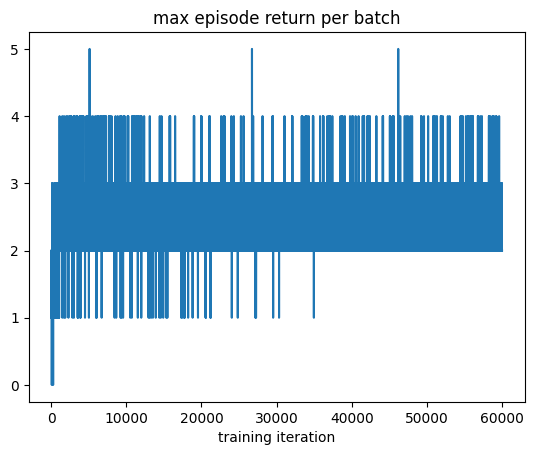

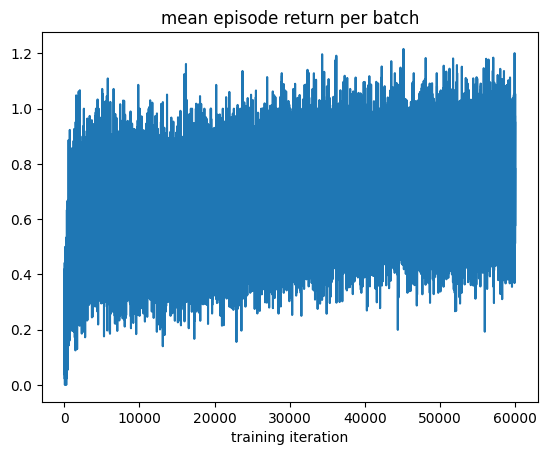

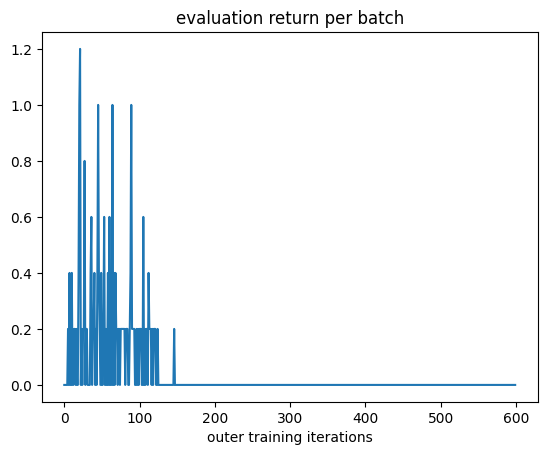

In [10]:
plt.plot(info["max_episode_return"])
plt.title("max episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["episode_return"])
plt.title("mean episode return per batch")
plt.xlabel("training iteration")
plt.show()

plt.plot(info["eval_return"])
plt.title("evaluation return per batch")
plt.xlabel("outer training iterations")
plt.show()


## Rollout Agent
We let the agent act greedily throughout an episode and visualise its behaviour.


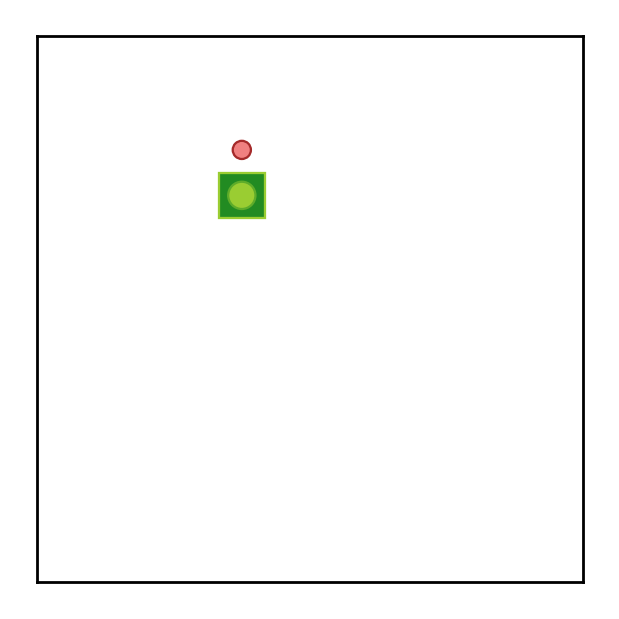

In [11]:
rng = jax.random.PRNGKey(0)

env = jumanji.make("Snake-v1")
state, timestep = env.reset(rng)
env_step = jax.jit(env.step)

DQN = build_dqn(env.action_spec().num_values)
initial_parameters = DQN.init(rng, timestep.observation)
policy = jax.jit(DQN.apply)

done = False
transitions = 0
while not done and transitions < 10:
    # select action greedily
    action = jnp.argmax(policy(params, timestep.observation))

    # take a step in the environment
    state, timestep = env_step(state, action)
    transitions += 1

    done = not timestep.discount

    env.render(state)


TODO: add a little summary of what was done and optionally an invitation to look at the full documentation, and potentially a take home message.

This notebook shows how to use and train an RL agent with the Jumanji API. We trained a DQN agent to play the Jumanji Snake environment under the Anakin Framework.    